# parameter tuned
reference : https://www.kaggle.com/znyksh/fork-lightgbm-with-simple-features/versions#base=4143658&new=4153250

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
!ls

aguiar's_kernel.ipynb
data_visualize.ipynb
feature_matrix.csv
feature_selection-feature_by_kageyama-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection-feature_by_olivier-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection_feature_matrix_by_kageyama.ipynb
feature_selection_feature_matrix_by_olivier.ipynb
feature_selection_feature_matrix_noIDs_by_kageyama.ipynb
featuretools-for-Kageyama.ipynb
featuretools-for-aguiar.ipynb
featuretools-for-olivier.ipynb
featuretools.ipynb
kageyama-25CV_noIDs_delunimportant_90.ipynb
kageyama-25CV_noIDs_delunimportant_92.ipynb
kageyama-25CV_noIDs_delunimportant_94.ipynb
kageyama-25CV_noIDs_delunimportant_96.ipynb
kageyama-25CV_noIDs_delunimportant_98.ipynb
kageyama_90_sub.csv
kageyama_94_sub.csv
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs.csv
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs_delmissing_delunimportant_794.csv
kageyama_feature_matrix_90.0.csv
kageyama_feature_matrix_92.0.csv
kageyama_feature_matrix_94.0.csv
kageyama_feature_mat

In [3]:
st = time.time()
df = pd.read_csv('./kageyama_feature_matrix_96.0.csv')
time.time() - st

69.93552041053772

In [4]:
df = df.drop('SK_ID_CURR', axis=1)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 21/21 [00:21<00:00,  1.02s/it]


36

In [6]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.759155	valid_1's auc: 0.752375
[200]	training's auc: 0.780746	valid_1's auc: 0.764549
[300]	training's auc: 0.798057	valid_1's auc: 0.77438
[400]	training's auc: 0.809735	valid_1's auc: 0.779619
[500]	training's auc: 0.819031	valid_1's auc: 0.782181
[600]	training's auc: 0.827091	valid_1's auc: 0.78451
[700]	training's auc: 0.834243	valid_1's auc: 0.7858
[800]	training's auc: 0.840561	valid_1's auc: 0.786683
[900]	training's auc: 0.846604	valid_1's auc: 0.787421
[1000]	training's auc: 0.852151	valid_1's auc: 0.788036
[1100]	training's auc: 0.85734	valid_1's auc: 0.78858
[1200]	training's auc: 0.861981	valid_1's auc: 0.78911
Early stopping, best iteration is:
[1198]	training's auc: 0.86187	valid_1's auc: 0.789113
Fold  1 AUC : 0.789113
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.75917	valid_1's auc: 0.748071
[200]	training's auc: 0.780504	valid_1's auc: 0.763

[200]	training's auc: 0.780822	valid_1's auc: 0.759761
[300]	training's auc: 0.798232	valid_1's auc: 0.76896
[400]	training's auc: 0.809674	valid_1's auc: 0.774484
[500]	training's auc: 0.819036	valid_1's auc: 0.777027
[600]	training's auc: 0.826937	valid_1's auc: 0.778474
[700]	training's auc: 0.833772	valid_1's auc: 0.779666
[800]	training's auc: 0.840113	valid_1's auc: 0.780274
[900]	training's auc: 0.846134	valid_1's auc: 0.781554
[1000]	training's auc: 0.851757	valid_1's auc: 0.782608
[1100]	training's auc: 0.857011	valid_1's auc: 0.783014
[1200]	training's auc: 0.861685	valid_1's auc: 0.78374
[1300]	training's auc: 0.866716	valid_1's auc: 0.78455
[1400]	training's auc: 0.871443	valid_1's auc: 0.785576
[1500]	training's auc: 0.875982	valid_1's auc: 0.785757
[1600]	training's auc: 0.880088	valid_1's auc: 0.786158
[1700]	training's auc: 0.884208	valid_1's auc: 0.786219
[1800]	training's auc: 0.888119	valid_1's auc: 0.786552
[1900]	training's auc: 0.891974	valid_1's auc: 0.78694
[200

[1700]	training's auc: 0.884044	valid_1's auc: 0.797084
[1800]	training's auc: 0.887889	valid_1's auc: 0.797294
[1900]	training's auc: 0.891638	valid_1's auc: 0.797184
Early stopping, best iteration is:
[1837]	training's auc: 0.889297	valid_1's auc: 0.797524
Fold 16 AUC : 0.797524
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.75891	valid_1's auc: 0.758752
[200]	training's auc: 0.780294	valid_1's auc: 0.772627
[300]	training's auc: 0.797537	valid_1's auc: 0.783029
[400]	training's auc: 0.80917	valid_1's auc: 0.788848
[500]	training's auc: 0.818622	valid_1's auc: 0.792048
[600]	training's auc: 0.826704	valid_1's auc: 0.794168
[700]	training's auc: 0.833876	valid_1's auc: 0.79514
[800]	training's auc: 0.840368	valid_1's auc: 0.796105
[900]	training's auc: 0.846425	valid_1's auc: 0.796719
[1000]	training's auc: 0.852078	valid_1's auc: 0.79732
[1100]	training's auc: 0.857272	valid_1's auc: 0.797518
Early stopping, best iteration is:
[1060]	training's

[900]	training's auc: 0.846459	valid_1's auc: 0.795659
[1000]	training's auc: 0.85169	valid_1's auc: 0.796486
[1100]	training's auc: 0.856923	valid_1's auc: 0.79693
[1200]	training's auc: 0.861713	valid_1's auc: 0.796911
[1300]	training's auc: 0.866442	valid_1's auc: 0.797039
[1400]	training's auc: 0.871001	valid_1's auc: 0.797222
[1500]	training's auc: 0.87535	valid_1's auc: 0.797172
[1600]	training's auc: 0.879681	valid_1's auc: 0.797842
[1700]	training's auc: 0.883908	valid_1's auc: 0.798046
[1800]	training's auc: 0.887847	valid_1's auc: 0.798433
[1900]	training's auc: 0.891545	valid_1's auc: 0.798578
Early stopping, best iteration is:
[1863]	training's auc: 0.890223	valid_1's auc: 0.798773
Fold 25 AUC : 0.798773
Full AUC score 0.793575


In [7]:
sub.to_csv('./kageyama_96_sub.csv', index=None)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


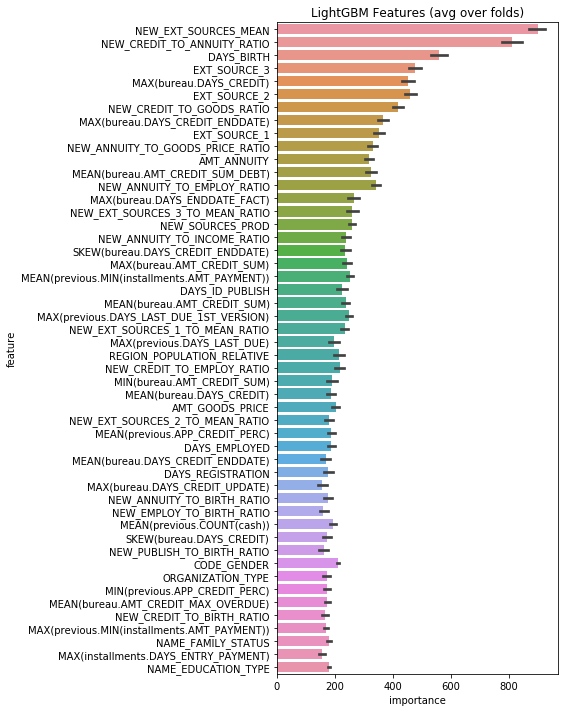

In [9]:
display_importances(feature_importance_df)

In [10]:
time.time() - st

13545.623369693756